In [8]:
import numpy as np
import sentinel_data_processing as sdp
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import folium

sdp.set_log_level(sdp.LogLevel.Debug)
mpl.rcParams['figure.dpi'] = 150

[2023-10-31 10:52:36.227] [info] Logging set to level: debug
[2023-10-31 10:52:36.227] [info] Log location: /home/ebiederstadt/masters/sentinel_data_processing/notebooks/logs/main.log


In [2]:
base_path = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570")
db = sdp.DataBase(str(base_path))
temporal = sdp.Temporal(db)

In [3]:
pixel_data =[
    [(57.022049,-111.837876), "Non-water"],
    [(56.9857286,-111.8650876), "Water (River)"],
    [(56.985953,-111.771001), "Water (Lake)"]
]

date = "2019-05-22"
result = temporal.nir_for_location(str(base_path), date, *pixel_data[0][0], 30)
water_result = temporal.nir_for_location(str(base_path), date, *pixel_data[1][0], 30)
cloud_result = temporal.nir_for_location(str(base_path), date, *pixel_data[2][0], 30)

In [4]:
def convert_dates(data):
    return [datetime(date.date.year, date.date.month, date.date.day) for date in data]

def seperate_by_clouds(values):
    vals_cloudy = []
    vals_non_cloudy = []

    for val in values:
        val.pydate = datetime(val.date.year, val.date.month, val.date.day)
        if val.clouds:
            vals_cloudy.append(val)
        else:
            vals_non_cloudy.append(val)

    return vals_cloudy, vals_non_cloudy

cloudy, non_cloudy = seperate_by_clouds(result)

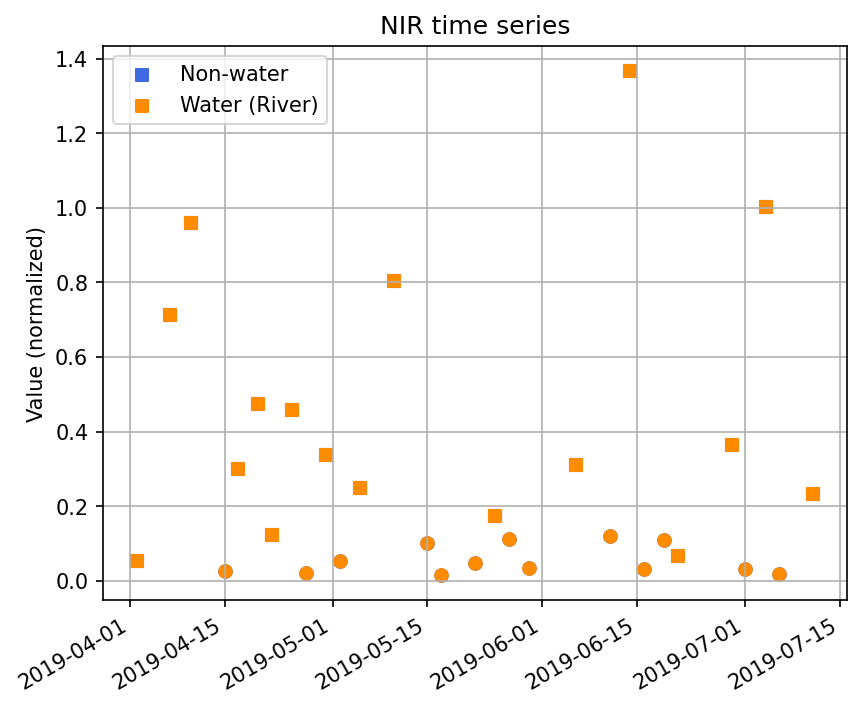

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter([x.pydate for x in cloudy], [x.value for x in cloudy], marker="s", c="royalblue", label=pixel_data[0][1])
ax.scatter([x.pydate for x in non_cloudy], [x.value for x in non_cloudy], marker="o", c="royalblue")

cloudy, non_cloudy = seperate_by_clouds(water_result)
ax.scatter([x.pydate for x in cloudy], [x.value for x in cloudy], marker="s", c="darkorange", label=pixel_data[1][1])
ax.scatter([x.pydate for x in non_cloudy], [x.value for x in non_cloudy], c="darkorange")

ax.set_title("NIR time series")
ax.grid()
ax.set_ylabel("Value (normalized)")
ax.legend()

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

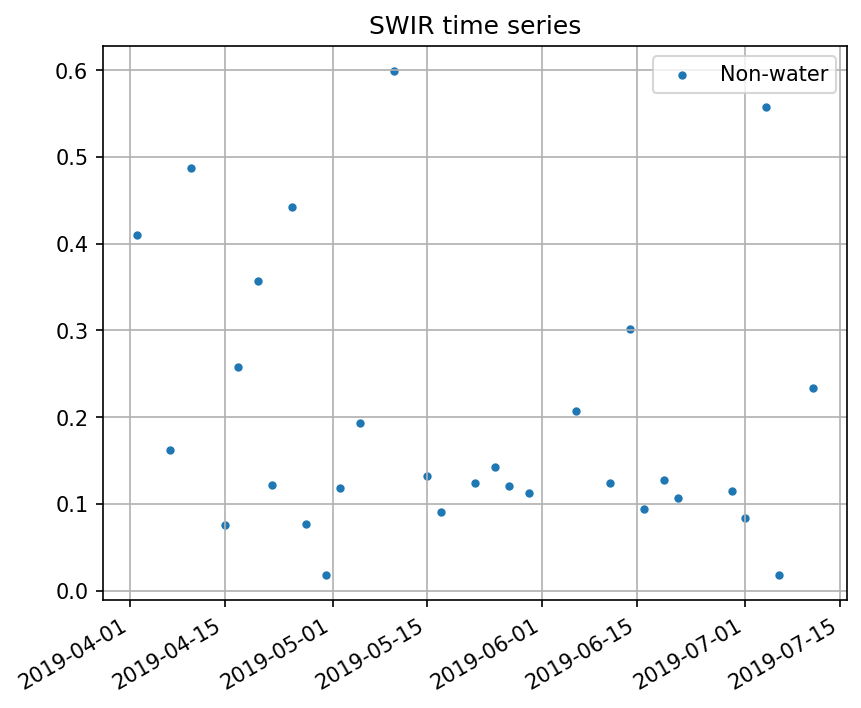

In [10]:
result = temporal.swir_for_location(str(base_path), date, *pixel_data[0][0], 30)

pydates = convert_dates(result)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(pydates, [x.value for x in result], label=pixel_data[0][1], marker=".")
ax.set_title("SWIR time series")
ax.legend()
ax.grid()

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

In [7]:
m = folium.Map(location=pixel_data[0][0])
folium.TileLayer('https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
	max_zoom= 17,
	attr='Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)'
).add_to(m)

for data in pixel_data:
    folium.Marker(location=data[0], tooltip=data[1], popup=data[1]).add_to(m)

m